# Scikit-Learn Pipeline Demo

A simple demo of pipeline building with scikit-learn, using the Boston Housing dataset
(data documentation [here](https://www.kaggle.com/c/boston-housing)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# data
from keras.datasets import boston_housing

In [2]:
# load dataset 
# x_test and y_test will be empty since test_split = 0
(x, y), (x_test, y_test) = boston_housing.load_data(test_split = 0.0, seed = 12345)
labels = ['crim', 'zn', 'indus', 'chas',
          'nox', 'rm', 'age', 'dis',
          'rad', 'tax', 'ptratio', 'black',
          'lstat']
datatype = ['cont', 'cont', 'cont', 'binary',
            'cont', 'cont', 'cont', 'cont',
            'cont', 'cont', 'cont', 'cont',
            'cont']
assert len(labels) == len(datatype)

In [3]:
# get dataframes for each segment of the data, for visualization purposes.
x_train = pd.DataFrame(x, columns = labels)
x_test = pd.DataFrame(x_test, columns = labels)
y_train = pd.DataFrame(y, columns = ['target'])
y_test = pd.DataFrame(y_test, columns = ['target'])

In [4]:
# describe the data so we can see what we are working with
x_train.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [5]:
y_train.describe()

,target
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [6]:
pd.concat([x_train, y_train], axis=1).head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,target
0,0.40771,0.0,6.20,1.0,0.507,6.164,91.3,3.0480,8.0,307.0,17.4,395.24,21.46,21.7
1,0.04417,70.0,2.24,0.0,0.400,6.871,47.4,7.8278,5.0,358.0,14.8,390.86,6.07,24.8
2,4.83567,0.0,18.10,0.0,0.583,5.905,53.2,3.1523,24.0,666.0,20.2,388.22,11.45,20.6
3,5.82401,0.0,18.10,0.0,0.532,6.242,64.7,3.4242,24.0,666.0,20.2,396.90,10.74,23.0
4,15.57570,0.0,18.10,0.0,0.580,5.926,71.0,2.9084,24.0,666.0,20.2,368.74,18.13,19.1


In [7]:
# Visualize the training data in a pairplot to see any colinearities or other interesting relationships.
# Note this is expensive to run, so we will skip this plot unless we set plotting to True.

#######################
# viz. training data
plotting = False
#######################
if plotting:
    plt.figure(figsize = (16,16))
    sns.pairplot(pd.concat([x_train, y_train], axis=1))
    plt.show();

In [8]:
####################
# separate continuous and binary features
####################

scaled_columns = []
for i, dtype in enumerate(datatype):
    if dtype == 'cont':
        scaled_columns += [labels[i]]
binary_columns = [label for label in labels
                  if label not in scaled_columns]
print('Continuous columns for transforming: \n    {}'.format(scaled_columns))
print('Binary columns: \n    {}'.format(binary_columns))

Continuous columns for transforming: 
    ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
Binary columns: 
    ['chas']


## Pipelining.

We will need pipelines that:

1) scale and "normalize" each continuous feature,
2) pass through the binary feature,
3) fit a regession model to the transformed data.

For 1 and 2, we an use the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) object to selectively scale the the continuous features and pass through the binary feature column unchanged. This is done by declaring a continuous feature transformer, `cont_transformer`, that applies a [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to center the continuous data columns around 0, and then a Yeo-Johnson [`PowerTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) to make the data look more "normal." This `cont_transformer` can then be added as the main step to both the input feature pipeline, `pipe_x`, and the target data pipeline, `pipe_y`. For `pipe_x`, `cont_transformer` is only applied to the continuous feature columns using the `ColumnTransformer` object.

For 3, we can just use a RandomForestRegressor model with the default parameters and 100 tree estimators. In practice, a grid search over models and model parameters could be used to optimize prediction performance.

In [9]:
#####################
# build pipelines
#####################

# pipeline steps for all continuous data
cont_transformer = Pipeline([
    ('cont_scaler', RobustScaler()),
    ('cont_transformer', PowerTransformer()),
])

# input feature pipeline
pipe_x = Pipeline([
    ('column_transform', ColumnTransformer([
        ('cont', cont_transformer, scaled_columns),
    ], remainder='passthrough')
    ),
    ('rfr', RandomForestRegressor(n_estimators=100))
])

# target feature pipeline
pipe_y = Pipeline([
    ('y_transforms', cont_transformer)
])

In [10]:
#######################################
# apply transforms and train model
#######################################
k_folds = 8  # cross validation 

# for each fold of the data, let's keep track of some metrics
metrics = {
    'r2': [],
    'mean_squared_error': [],
    'mean_abs_error': [],
}

# keep track of true and predicted target data for visualization
output_data = {
    'y_true': {},
    'y_pred': {},
}

kf = KFold(n_splits=k_folds, shuffle=True, random_state=12345) # k-fold cross validation
for i, (train_ind, test_ind) in enumerate(kf.split(x_train, y_train)):
    kf_x_train, kf_x_test = x_train.iloc[train_ind], x_train.iloc[test_ind]
    kf_y_train, kf_y_test = y_train.iloc[train_ind], y_train.iloc[test_ind]
    
    # get pipeline data
    y_train_ = pipe_y.fit_transform(kf_y_train)
    pipe_x.fit(kf_x_train, y_train_)
    x_train_ = pipe_x['column_transform'].transform(kf_x_train)

    #######################################
    # get modeling results
    #######################################
    # get prediction results
    y_pred_ = pipe_x.predict(kf_x_test)
    y_pred = pipe_y.inverse_transform(y_pred_.reshape(-1, 1))
    
    # record predicted and true data
    output_data['y_true'][i] = kf_y_test.values[:,0]
    output_data['y_pred'][i] = y_pred[:,0]

    # score prediction results
    r2_res = r2_score(kf_y_test.values[:,0], y_pred[:,0])
    mean_squared_res = mean_squared_error(kf_y_test.values[:,0], y_pred[:,0])
    mean_absolute_res = mean_absolute_error(kf_y_test.values[:,0], y_pred[:,0])
    metrics['r2'] += [r2_res]
    metrics['mean_squared_error'] += [mean_squared_res]
    metrics['mean_abs_error'] += [mean_absolute_res]
    print('\nFOLD: {}'.format(i+1))
    print('METRICS: \n    r2: {:.4f} \n    mean squared error: {:.2f} (Thousand $)^2 \n    mean abs error: {:.2f} Thousand $  '.format(r2_res,
                                                                                                                        mean_squared_res,
                                                                                                                        mean_absolute_res))
print()
print('%%%%%%%%%%%%%%%%%%%%%%%%')
print()
print('Metric results (target units in Thousands of $):')
for metric in metrics.keys():
    print('    {} Result: {:.4f} +/- {:.4f}'.format(metric, np.mean(metrics[metric]), 2.*np.std(metrics[metric])))
    print('        {} median: {:.4f}'.format(metric, np.median(metrics[metric])))
    print()



FOLD: 1
METRICS: 
    r2: 0.8658 
    mean squared error: 7.22 (Thousand $)^2 
    mean abs error: 2.07 Thousand $  

FOLD: 2
METRICS: 
    r2: 0.7937 
    mean squared error: 20.51 (Thousand $)^2 
    mean abs error: 2.29 Thousand $  

FOLD: 3
METRICS: 
    r2: 0.7347 
    mean squared error: 14.18 (Thousand $)^2 
    mean abs error: 2.68 Thousand $  

FOLD: 4
METRICS: 
    r2: 0.8901 
    mean squared error: 9.21 (Thousand $)^2 
    mean abs error: 1.96 Thousand $  

FOLD: 5
METRICS: 
    r2: 0.8802 
    mean squared error: 13.66 (Thousand $)^2 
    mean abs error: 2.51 Thousand $  

FOLD: 6
METRICS: 
    r2: 0.8458 
    mean squared error: 9.26 (Thousand $)^2 
    mean abs error: 2.11 Thousand $  

FOLD: 7
METRICS: 
    r2: 0.9119 
    mean squared error: 6.96 (Thousand $)^2 
    mean abs error: 1.89 Thousand $  

FOLD: 8
METRICS: 
    r2: 0.9246 
    mean squared error: 9.50 (Thousand $)^2 
    mean abs error: 2.16 Thousand $  

%%%%%%%%%%%%%%%%%%%%%%%%

Metric results (target uni

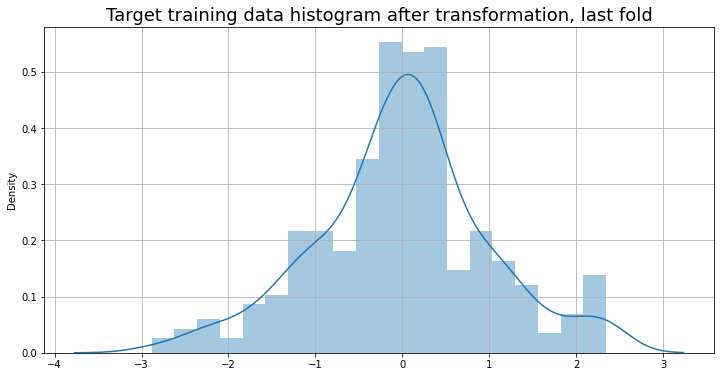

In [11]:
plt.figure(figsize = (12,6))
sns.distplot(pd.DataFrame(y_train_, columns = ['target']))
plt.grid()
plt.title('Target training data histogram after transformation, last fold', fontsize = 18)
plt.show();

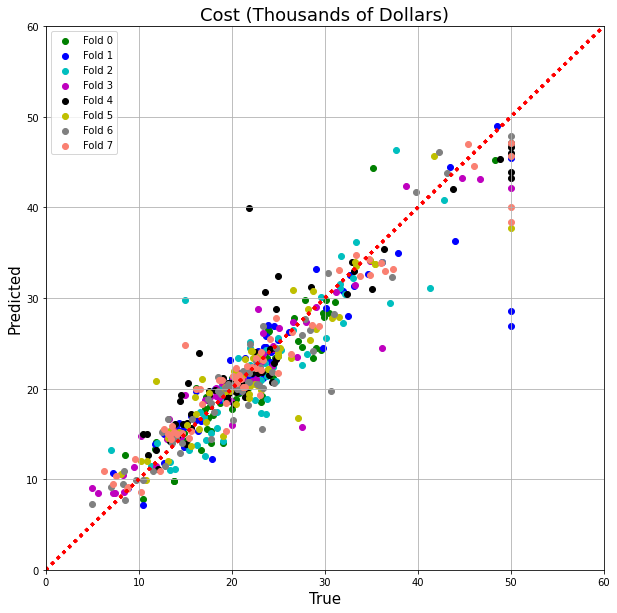

In [12]:
plt.figure(figsize=(10, 10))
colors = ['g', 'b', 'c', 'm', 'k', 'y', 'grey', 'salmon', 'lime', 'brown']
for i in output_data['y_pred'].keys():
    plt.scatter(output_data['y_true'][i], 
                output_data['y_pred'][i],
                c = colors[i%len(colors)],
                label = 'Fold {}'.format(i))
    plt.plot([0, 60],
             [0, 60],
             ls = ':',
             c = 'r',
             lw = 3)
plt.title('Cost (Thousands of Dollars)', fontsize = 18)
plt.xlabel('True', fontsize = 15)
plt.grid()
plt.ylabel('Predicted', fontsize = 15)
plt.legend()
plt.xlim([0,60])
plt.ylim([0,60])
plt.show();

In [13]:
#######################
# viz. training data after transforms
plotting = False
#######################
if plotting:
    plt.figure(figsize = (16,16))
    sns.pairplot(pd.DataFrame(x_train_, columns = labels))
    plt.show();